# **Tabular Playground Series - Feb 2022. Bacteria species classification**
https://www.kaggle.com/competitions/tabular-playground-series-feb-2022/

Installazione pacchetti necessari e import.

In [ ]:
!pip install opendatasets

In [3]:
import sklearn as sk
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import opendatasets as od

Import del dataset. Essendo questa una competizione, il dataset sarà già diviso in train/test set.

In [ ]:
dataset_link = "https://www.kaggle.com/competitions/tabular-playground-series-feb-2022"
od.download(dataset_link)

In [5]:
train_dataset_path = "./tabular-playground-series-feb-2022/train.csv"
test_dataset_path = "./tabular-playground-series-feb-2022/test.csv"

train_dataset = pd.read_csv(train_dataset_path, index_col = "row_id")
test_dataset = pd.read_csv(test_dataset_path, index_col = "row_id")

In [5]:
train_dataset.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
row_id,,,,,,,,,,,,,,,,,,,,,
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [6]:
X_train = train_dataset.copy()
y_train = X_train.pop("target")

X_test = test_dataset.copy()

In [10]:
def calc_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features)
  mi_scores = pd.Series(data = mi_scores, index = X.columns)
  mi_scores = mi_scores.sort_values(ascending = False)
  return mi_scores

In [11]:
def plot_mi_scores(scores):
  scores = scores.sort_values(ascending = True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

In [ ]:
for col in X_train.select_dtypes("category"):
  X_train[col] = X_train[col].factorize()

discrete_features = X_train.dtypes == int

mi_scores = calc_mi_scores(X_train, y_train, discrete_features = discrete_features)

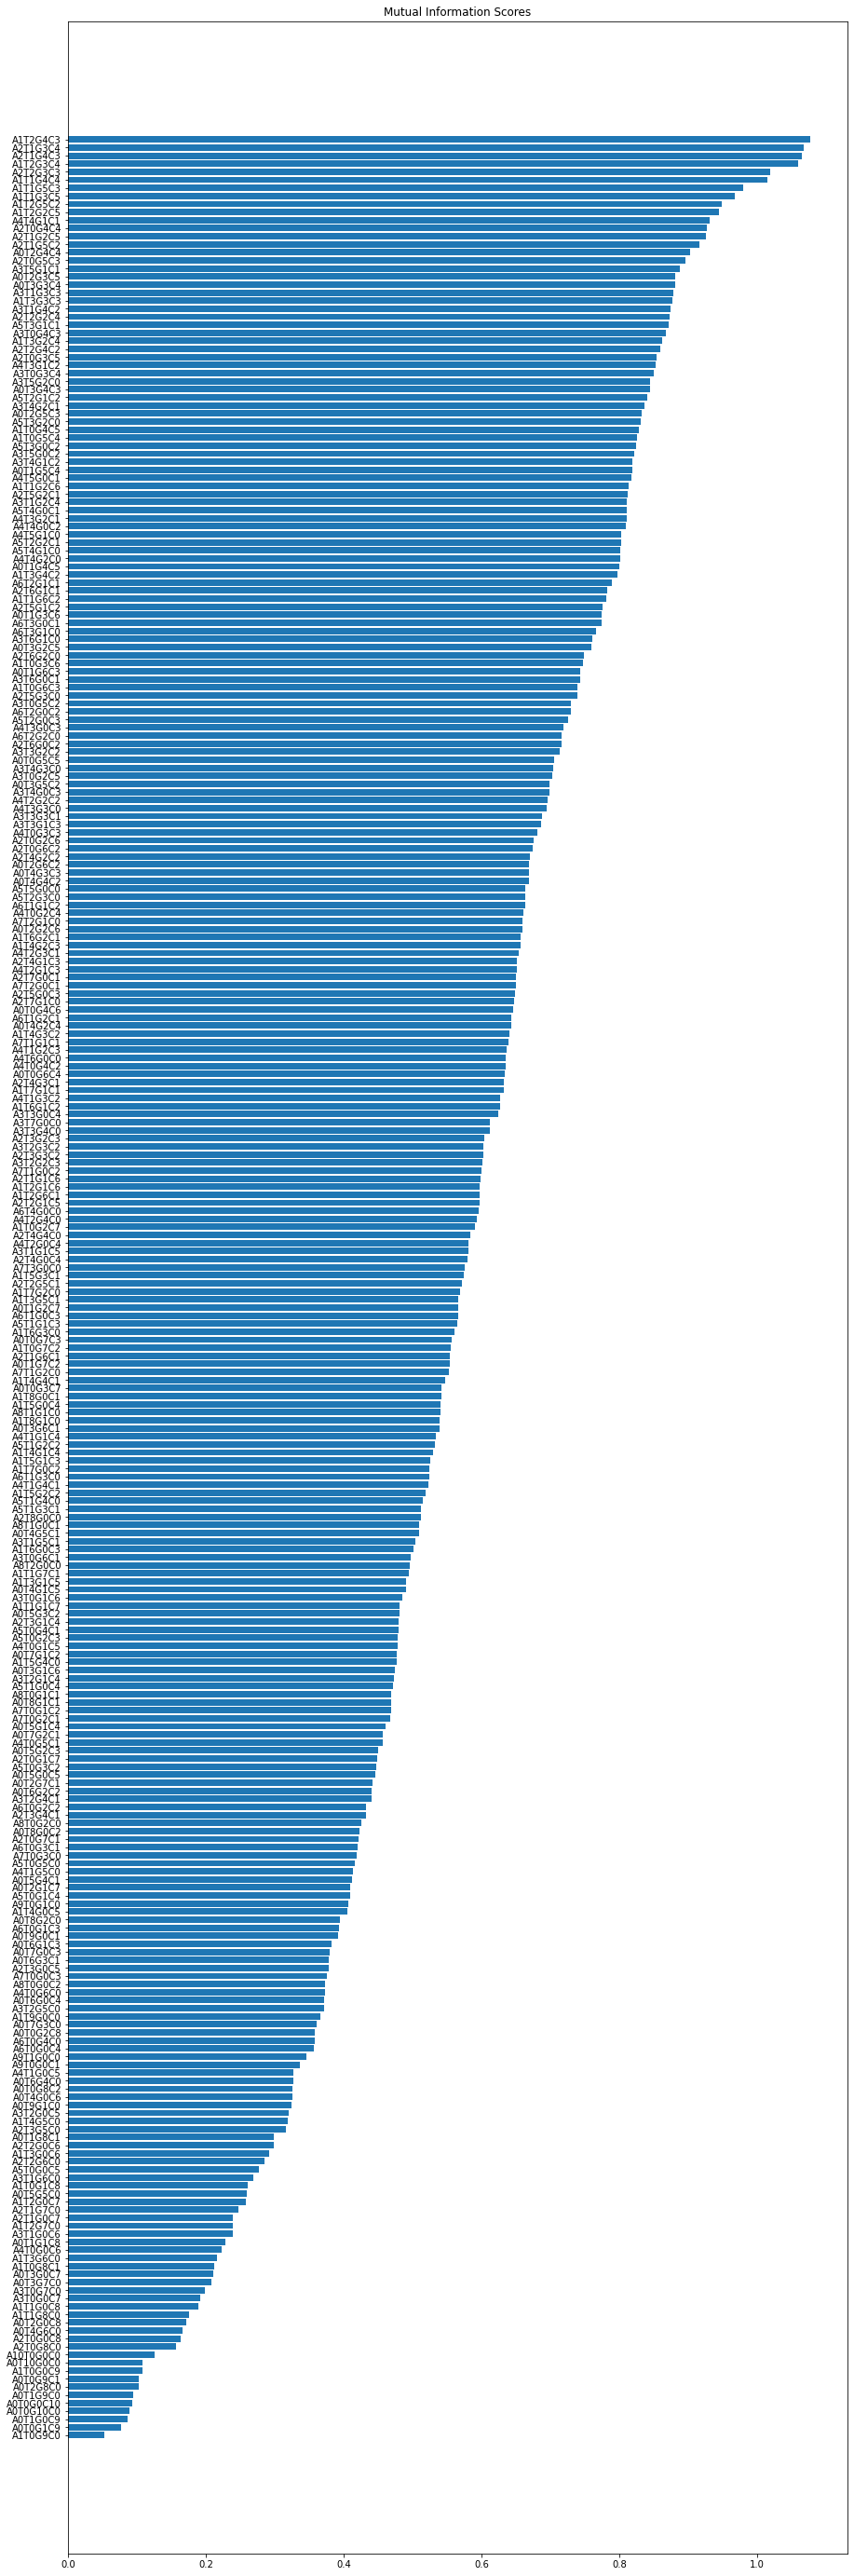

In [10]:
plt.figure(figsize = (15, 50))
plot_mi_scores(mi_scores)

In [11]:
# Funzione custom per effettuare la nested cross validation
def nested_cross_validation(model, X, y, parameters = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}, num_trials = 30):
  # Arrays in cui conservare i vari scores
  non_nested_scores = np.zeros(num_trials)
  nested_scores = np.zeros(num_trials)

  # Loop per ogni singolo trial
  for i in range(num_trials):

      # Choose cross-validation techniques for the inner and outer loops,
      # independently of the dataset.
      # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
      inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
      outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

      # Non_nested parameter search and scoring
      clf = GridSearchCV(estimator=model, param_grid=parameters, cv=outer_cv)
      clf.fit(X, y)
      non_nested_scores[i] = clf.best_score_

      # Nested CV with parameter optimization
      clf = GridSearchCV(estimator=model, param_grid=parameters, cv=inner_cv)
      nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
      nested_scores[i] = nested_score.mean()

  score_difference = non_nested_scores - nested_scores
  return score_difference

In [13]:
xgb_model = XGBClassifier()
random_forest_model = RandomForestClassifier()

In [ ]:
#xgb_score = nested_cross_validation(xgb_model, X_train, y_train)
#xgb_score

In [ ]:
#random_forest_score = nested_cross_validation(random_forest_model, X_train, y_train)
#random_forest_score

In [14]:
xgb_score = cross_val_score(xgb_model, X_train, y_train)
print(xgb_score.mean())

0.8487199999999999


In [ ]:
#random_forest_score = cross_val_score(random_forest_model, X_train, y_train)
#print(random_forest_score.mean())

In [ ]:
#random_forest_model.fit(X_train, y_train)
#y_hat_test_random_forest = random_forest_model.predict(X_test)
#y_hat_test_random_forest

In [ ]:
xgb_model.fit(X_train, y_train)
y_hat_test = xgb_model.predict(X_test)
y_hat_test

In [20]:
submission_link = "./tabular-playground-series-feb-2022/sample_submission.csv"
submission = pd.read_csv(submission_link)
submission["target"] = y_hat_test
submission.to_csv("./tabular-playground-series-feb-2022/submission.csv", index = False)